<a href="https://colab.research.google.com/github/MonitSharma/Learn-Quantum-Machine-Learning/blob/main/Running_Pennylane_in_AWS_Bracket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computing gradients in parallel with Amazon Braket

PennyLane integrates with [Amazon Braket](https://aws.amazon.com/braket/) to enable quantum machine learning and optimization on high-performance simulators and quantum processing units (QPUs) through a range of [providers](https://aws.amazon.com/braket/hardware-providers/).

In PennyLane, Amazon Braket is accessed through the [PennyLane-Braket](https://amazon-braket-pennylane-plugin-python.readthedocs.io/) plugin. The plugin can be installed using:

## Note:

To access remote services on Amazon Braket, you must first create an account on AWS and also follow the [setup instructions](https://github.com/aws/amazon-braket-sdk-python#prerequisites) for accessing Braket from Python.

In [ ]:
!pip install amazon-braket-pennylane-plugin

A central feature of Amazon Braket is that its remote simulator can execute multiple circuits in parallel. This capability can be harnessed in PennyLane during circuit training, which requires lots of variations of a circuit to be executed. Hence, the PennyLane-Braket plugin provides a method for scalable optimization of large circuits with many parameters. This tutorial will explain the importance of this feature, allow you to benchmark it yourself, and explore its use for solving a scaled-up graph problem with QAOA.



![aws bracket](https://pennylane.ai/qml/_images/remote-multi-job-simulator.png)


# Why is training circuits so expensive?

Quantum-classical hybrid optimization of quantum circuits is the workhorse algorithm of near-term quantum computing. It is not only fundamental for training variational quantum circuits, but also more broadly for applications like quantum chemistry and quantum machine learning. Today’s most powerful optimization algorithms rely on the efficient computation of gradients—which tell us how to adapt parameters a little bit at a time to improve the algorithm.

-----


Calculating the gradient involves multiple device executions: for each trainable parameter we must execute our circuit on the device typically more than once. Reasonable applications involve many trainable parameters (just think of a classical neural net with millions of tunable weights). The result is a huge number of device executions for each optimization step.



![optimization](https://pennylane.ai/qml/_images/grad-circuits.png)





------


In the standard `default.qubit` device, gradients are calculated in PennyLane through sequential device executions—in other words, all these circuits have to wait in the same queue until they can be evaluated. This approach is simpler, but quickly becomes slow as we scale the number of parameters. Moreover, as the number of qubits, or “width”, of the circuit is scaled, each device execution will slow down and eventually become a noticeable bottleneck. In short—**the future of training quantum circuits relies on high-performance remote simulators and hardware devices that are highly parallelized**.



Fortunately, the PennyLane-Braket plugin provides a solution for scalable quantum circuit training by giving access to the Amazon Braket simulator known as [SV1](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html). SV1 is a high-performance state vector simulator that is designed with parallel execution in mind. Together with PennyLane, we can use SV1 to run in parallel all the circuits needed to compute a gradient!








# Accessing devices on Amazon Braket

The remote simulator and quantum hardware devices available on Amazon Braket can be found [here](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html). Each device has a unique identifier known as an [ARN](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html). In PennyLane, all remote Braket devices are accessed through a single PennyLane device named `braket.aws.qubit`, along with specification of the corresponding ARN.

Let’s load the SV1 simulator in PennyLane with 25 qubits. We must specify both the ARN and the address of the [S3 bucket](https://aws.amazon.com/s3/) where results are to be stored:

In [ ]:
my_bucket = "amazon-braket-Your-Bucket-Name"  # the name of the bucket, keep the 'amazon-braket-' prefix and then include the bucket name
my_prefix = "Your-Folder-Name"  # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

SV1 can now be loaded with the standard PennyLane `device()`:

In [ ]:
import pennylane as qml
from pennylane import numpy as np

n_wires = 25

dev_remote = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=n_wires,
    s3_destination_folder=s3_folder,
    parallel=True,
)

Note the `parallel=True` argument. This setting allows us to unlock the power of parallel execution on SV1 for gradient calculations. We’ll also load `default.qubit` for comparison.

In [ ]:
dev_local = qml.device("default.qubit", wires=n_wires)

Note that a local Braket device `braket.local.qubit` is also available. See the documentation for more details.

# Benchmarking circuit evaluationo

We will now compare the execution time for the remote Braket SV1 device and `default.qubit`. Our first step is to create a simple circuit:



In [ ]:
def circuit(params):
    for i in range(n_wires):
        qml.RX(params[i], wires=i)
    for i in range(n_wires):
        qml.CNOT(wires=[i, (i + 1) % n_wires])

    # Measure all qubits to make sure all's good with Braket
    observables = [qml.PauliZ(n_wires - 1)] + [qml.Identity(i) for i in range(n_wires - 1)]
    return qml.expval(qml.operation.Tensor(*observables))

![circuit](https://pennylane.ai/qml/_images/circuit.png)

In this circuit, each of the 25 qubits has a controllable rotation. A final block of two-qubit CNOT gates is added to entangle the qubits. Overall, this circuit has 25 trainable parameters. Although not particularly relevant for practical problems, we can use this circuit as a testbed for our comparison.

The next step is to convert the above circuit into a PennyLane `QNode()`.

In [ ]:
qnode_remote = qml.QNode(circuit, dev_remote)
qnode_local = qml.QNode(circuit, dev_local)

## Note:
The above uses `QNode()` to convert the circuit. In other tutorials, you may have seen the qnode() decorator being used. These approaches are interchangeable, but we use `QNode()` here because it allows us to pair the same circuit to different devices.

## Warning:

Running the contents of this tutorial will result in simulation fees charged to your AWS account. We recommend monitoring your usage on the AWS dashboard.

Let's compare the execution time between the two

In [ ]:
import time

params = np.random.random(n_wires)

t_0_remote = time.time()
qnode_remote(params)
t_1_remote = time.time()

t_0_local = time.time()
qnode_local(params)
t_1_local = time.time()

print("Execution time on remote device (seconds):", t_1_remote - t_0_remote)
print("Execution time on local device (seconds):", t_1_local - t_0_local)

These timings highlight the advantage of using the Amazon Braket SV1 device for simulations with large qubit numbers. In general, simulation times scale exponentially with the number of qubits, but SV1 is highly optimized and running on AWS remote servers. This allows SV1 to outperform `default.qubit` in this 25-qubit example. The time you see in practice for the remote device will also depend on factors such as your distance to AWS servers.




## Note:

Given these timings, why would anyone want to use `default.qubit`? You should consider using local devices when your circuit has few qubits. In this regime, the latency times of communicating the circuit to a remote server dominate over simulation times, allowing local simulators to be faster.


# Benchmarking Gradient calculations

Now let us compare the gradient-calculation times between the two devices. Remember that when loading the remote device, we set `parallel=True`. This allows the multiple device executions required during gradient calculations to be performed in parallel, so we expect the remote device to be much faster.

First, consider the remote device:


In [ ]:
d_qnode_remote = qml.grad(qnode_remote)

t_0_remote_grad = time.time()
d_qnode_remote(params)
t_1_remote_grad = time.time()

print("Gradient calculation time on remote device (seconds):", t_1_remote_grad - t_0_remote_grad)

Now, the local device:


## Warning:

Evaluating the gradient with default.qubit will take a long time, consider commenting-out the following lines unless you are happy to wait.

In [ ]:
d_qnode_local = qml.grad(qnode_local)

t_0_local_grad = time.time()
d_qnode_local(params)
t_1_local_grad = time.time()

print("Gradient calculation time on local device (seconds):", t_1_local_grad - t_0_local_grad)

The local device needs around 15 minutes or more! Compare this to less than a minute spent calculating the gradient on SV1. This provides a powerful lesson in parallelization.

What if we had run on SV1 with `parallel=False`? It would have taken around 3 minutes—still faster than a local device, but much slower than running SV1 in parallel.

# Scaling up QAOA for larger graphs

The quantum approximate optimization algorithm (QAOA) is a candidate algorithm for near-term quantum hardware that can find approximate solutions to combinatorial optimization problems such as graph-based problems. We have seen in the main [QAOA tutorial](https://colab.research.google.com/github/MonitSharma/Learn-Quantum-Machine-Learning/blob/main/Intro_to_QAOA.ipynb) how QAOA successfully solves the minimum vertex cover problem on a four-node graph.

Here, let’s be ambitious and try to solve the maximum cut problem on a twenty-node graph! In maximum cut, the objective is to partition the graph’s nodes into two groups so that the number of edges crossed or ‘cut’ by the partition is maximized (see the diagram below). This problem is NP-hard, so we expect it to be tough as we increase the number of graph nodes.



![alt](https://pennylane.ai/qml/_images/max-cut.png)

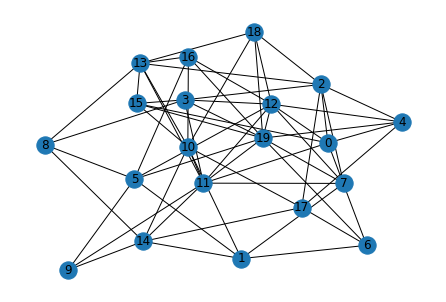

In [1]:
import networkx as nx

nodes = n_wires = 20
edges = 60
seed = 1967

g = nx.gnm_random_graph(nodes, edges, seed=seed)
positions = nx.spring_layout(g, seed=seed)

nx.draw(g, with_labels=True, pos=positions)

We will use the remote SV1 device to help us optimize our QAOA circuit as quickly as possible. First, the device is loaded again for 20 qubits

In [ ]:
dev = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=n_wires,
    s3_destination_folder=s3_folder,
    parallel=True,
    max_parallel=20,
    poll_timeout_seconds=30,
)

Note the specification of max_parallel=20. This means that up to 20 circuits will be executed in parallel on SV1 (the default value is 10).

## Warning:
Increasing the maximum number of parallel executions can result in a greater rate of spending on simulation fees on Amazon Braket. The value must also be set bearing in mind your service [quota](https://docs.aws.amazon.com/braket/latest/developerguide/braket-quotas.html).

The QAOA problem can then be set up following the standard pattern, as discussed in detail in the [QAOA tutorial](https://colab.research.google.com/github/MonitSharma/Learn-Quantum-Machine-Learning/blob/main/Intro_to_QAOA.ipynb).

In [2]:
cost_h, mixer_h = qml.qaoa.maxcut(g)
n_layers = 2


def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, cost_h)
    qml.qaoa.mixer_layer(alpha, mixer_h)


def circuit(params, **kwargs):
    for i in range(n_wires):  # Prepare an equal superposition over all qubits
        qml.Hadamard(wires=i)

    qml.layer(qaoa_layer, n_layers, params[0], params[1])
    return qml.expval(cost_h)


cost_function = qml.QNode(circuit, dev)
optimizer = qml.AdagradOptimizer(stepsize=0.1)

We’re now set up to train the circuit! Note, if you are training this circuit yourself, you may want to increase the number of iterations in the optimization loop and also investigate changing the number of QAOA layers

## Warning:
The following lines are computationally intensive. Remember that running it will result in simulation fees charged to your AWS account. We recommend monitoring your usage on the AWS dashboard.

In [ ]:
import time

np.random.seed(1967)
params = 0.01 * np.random.uniform(size=[2, n_layers], requires_grad=True)
iterations = 10

for i in range(iterations):
    t0 = time.time()

    params, cost_before = optimizer.step_and_cost(cost_function, params)

    t1 = time.time()

    if i == 0:
        print("Initial cost:", cost_before)
    else:
        print(f"Cost at step {i}:", cost_before)

    print(f"Completed iteration {i + 1}")
    print(f"Time to complete iteration: {t1 - t0} seconds")

print(f"Cost at step {iterations}:", cost_function(params))

np.save("params.npy", params)
print("Parameters saved to params.npy")


This example shows us that a 20-qubit QAOA problem can be trained within around 1-2 minutes per iteration by using parallel executions on the Amazon Braket SV1 device to speed up gradient calculations. If this problem were run on default.qubit without parallelization, we would expect for training to take much longer.

